<a href="https://colab.research.google.com/github/FILIPNFT/FILIPNFT/blob/main/NMDomaci2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import confusion_matrix

In [19]:
# Transformacije za trening set sa augmentacijom
train_transforms = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Standardne transformacije za test set
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

# Učitavanje trening i test skupa podataka
trainset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=True, transform=train_transforms)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)

testset = datasets.FashionMNIST('~/.pytorch/F_MNIST_data/', download=True, train=False, transform=test_transforms)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)


In [20]:
class FashionCNN(nn.Module):
    def __init__(self):
        super(FashionCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64 * 7 * 7, 256)
        self.fc2 = nn.Linear(256, 10)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 7 * 7)
        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        return x

model = FashionCNN()

In [21]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

epochs = 10
for epoch in range(epochs):
    running_loss = 0
    for images, labels in trainloader:
        optimizer.zero_grad()
        output = model(images)
        loss = criterion(output, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f'Epoch {epoch + 1} - Training loss: {running_loss/len(trainloader)}')


Epoch 1 - Training loss: 0.5790881803358542
Epoch 2 - Training loss: 0.4002578486321069
Epoch 3 - Training loss: 0.34971058824613915
Epoch 4 - Training loss: 0.3220255351873603
Epoch 5 - Training loss: 0.30162463797085576
Epoch 6 - Training loss: 0.28702389953264806
Epoch 7 - Training loss: 0.2726556536501277
Epoch 8 - Training loss: 0.26320362098213196
Epoch 9 - Training loss: 0.25337649933469575
Epoch 10 - Training loss: 0.2473667047616007


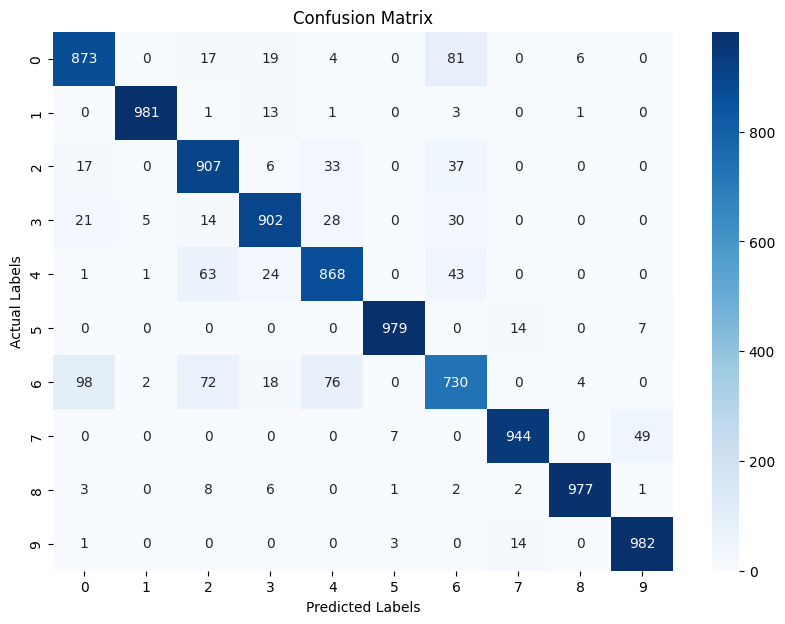

In [22]:
def evaluate_model(loader):
    y_pred = []
    y_true = []
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            output = model(images)
            _, predicted = torch.max(output, 1)
            y_pred.extend(predicted.numpy())
            y_true.extend(labels.numpy())
    return y_true, y_pred

y_true, y_pred = evaluate_model(testloader)

cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=[i for i in range(10)], columns=[i for i in range(10)])

plt.figure(figsize=(10,7))
sns.heatmap(cm_df, annot=True, fmt='g', cmap='Blues')
plt.title('Confusion Matrix')
plt.ylabel('Actual Labels')
plt.xlabel('Predicted Labels')
plt.show()



In [23]:
def calculate_accuracy(model, loader):
    correct = 0
    total = 0
    model.eval()
    with torch.no_grad():
        for images, labels in loader:
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = 100 * correct / total
    return accuracy

# Pozivanje funkcije i ispis tačnosti
accuracy = calculate_accuracy(model, testloader)
print(f'Accuracy of the model on the test images: {accuracy:.2f}%')


Accuracy of the model on the test images: 91.43%


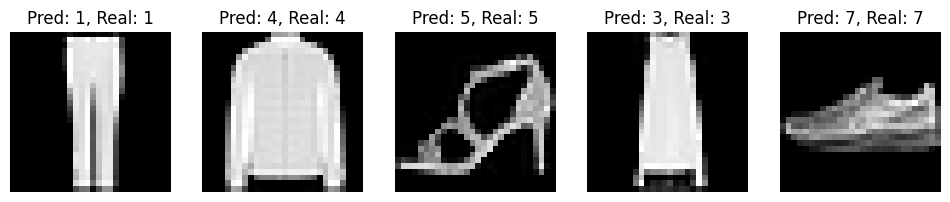

In [27]:
import matplotlib.pyplot as plt

def visualize_predictions(model, loader, num_images=5):
    images, labels = next(iter(loader))
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)

    plt.figure(figsize=(12, 8))
    for i in range(num_images):
        ax = plt.subplot(1, num_images, i + 1)
        img = images[i].numpy().squeeze()
        ax.imshow(img, cmap='gray')
        ax.set_title(f'Pred: {predicted[i].item()}, Real: {labels[i].item()}')
        ax.axis('off')
    plt.show()

# Pozivanje funkcije za vizualizaciju
visualize_predictions(model, testloader)
